# NIH Grant Tracking with Spark

## Phase I: Develop and Test

In this notebook, I will explore the NIH grant tracking project in the spark framework. First of all, let's run some development process with a smaller data set from the grant abstracts residing in the local `Data/PRJABS/` folder.

In [17]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import os
import dill
import re
from tqdm import tqdm_notebook
import pickle
import matplotlib.pyplot as plt
from nltk.stem.porter import *
sns.set()
matplotlib.rcParams['figure.dpi'] = 144

Start the spark section:

In [20]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import *

sc = SparkContext("local[*]", "temp")
sqlContext = SQLContext(sc)

Define the local file path conversion function:

In [21]:
def localpath(path):
    return 'file://' + os.path.join(os.path.abspath(os.path.curdir), path)

Before we scale up, we need to develop the algorithm in a smaller test case. I make a test folder with the grant abstract in 1985:

In [6]:
from shutil import copyfile
if os.path.exists('Data/test/'):
    os.system('rm -r Data/test')
os.mkdir('Data/test/')
fns = os.listdir('Data/PRJABS/')
for fn in sorted(fns)[:1]:
    copyfile(os.path.join('Data/PRJABS/',fn),
             os.path.join('Data/test/',fn))

I will test the NLP pipelines using different methods

In [2]:
proj_ABS = pd.read_csv(os.path.join('Data/test/',os.listdir('Data/test/')[0]),
                       header = 0,
                       dtype = {'APPLICATION_ID': str,'ABSTRACT_TEXT': str},
                       engine = 'python')
proj_ABS.head()

,APPLICATION_ID,ABSTRACT_TEXT
0,3126545,The aim of this proposal is an understanding o...
1,3126549,The alternative pathway of complement activati...
2,3126553,We will study virus-host cell interactions wit...
3,3109190,Chronic ingestion of enthanol impairs the cont...
4,3109194,The effects of ethanol exposure on central ner...


### Text tokenization and cleaning

First, we need to preprocess the abstract texts to clean up punctuations/stop words/some redundant words, get the lemma of the words:

In [3]:
#Text Cleaning
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

#word lemmatize to get the root word
import nltk
# nltk.download('wordnet') # comment out during the first time running
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

#clean stop words
# nltk.download('stopwords') # comment out during the first time running
en_stop = set(nltk.corpus.stopwords.words('english'))
rm_words = ['nan','cell']

#ensemble function
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    # exclude single letters
    tokens = [token for token in tokens if len(token) > 1]
    # clean stop words
    tokens = [token for token in tokens if token not in en_stop]
    # find the lemmas
    tokens = [get_lemma2(token) for token in tokens]
    # clean the customized word removing
    tokens = [token for token in tokens if token not in rm_words]
    return tokens

In [4]:
tokens = [prepare_text_for_lda(abs) for abs in proj_ABS['ABSTRACT_TEXT']]

### Build the LDA model using the Gensim package:

In [6]:
from gensim import corpora
from gensim.models import TfidfModel
# get the bag-of-word
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
# fit the tfidf model
tfidf_model = TfidfModel(corpus)
# apply the model to all the corpus
tfidf_vector = tfidf_model[corpus]
import gensim
# build LDA model with 10 topics
NUM_TOPICS = 10
lda = gensim.models.ldamodel.LdaModel(tfidf_vector, num_topics = NUM_TOPICS, 
                                           id2word=dictionary, passes=15)

In [ ]:
import pyLDAvis
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, 
                                      sort_topics=True, mds='mmds')

In [44]:
pyLDAvis.display(lda_display)

Load the abstract content in the test folder into spark, clean text, tokenize the corpus, and stem the words:

### How many topics are good?

We chose 10 topics for the convenience in the previous section. Here, we will optimize the number of topics using the LDA model in the gensim framework. We will need to have some metrics to measure the goodness of the topic modeling. [Coherence measures](http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf) can be used to evaluate the comprehansiveness of the topics. It is separated into 4 stages:
- Segmentation
- Probability Estimation
- Confirmation Measure
- Aggregation

All those 4 stages are conveniently implemented in the gensim pipeline `CoherenceModel`. 

In [10]:
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
def evaluate_graph(dictionary, corpus, texts, limit):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        tfidf_model = TfidfModel(corpus)
        # apply the model to all the corpus
        tfidf_vector = tfidf_model[corpus]
        lm = LdaModel(corpus=tfidf_vector, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

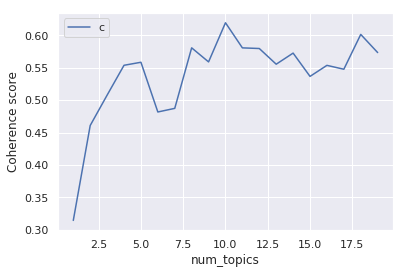

In [11]:
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=tokens, limit=20)

**Conclusions**

The figure clearly show that *10 topics* works the best! 

### Which models are good?

There are three main topic models: latent semantic indexing utilizing the SVD for demention reduction, Hierarchical Dirichlet Process infers the number of topics from the data, and LDA as the industry leader in terms of the performance. In this section, we will use the coherence measures to evaluate which models work best for our topic modeling.

In [12]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)
lsitopics = lsimodel.show_topics(formatted=False)
lsitopics = [[word for word, prob in topic] for topicid, topic in lsitopics]
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)
hdptopics = hdpmodel.show_topics(formatted=False)
hdptopics = [[word for word, prob in topic] for topicid, topic in hdptopics]
ldatopics = lda.show_topics(formatted=False)
ldatopics = [[word for word, prob in topic] for topicid, topic in ldatopics]

In [14]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=tokens, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=tokens, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=tokens, dictionary=dictionary, window_size=10).get_coherence()

In [15]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

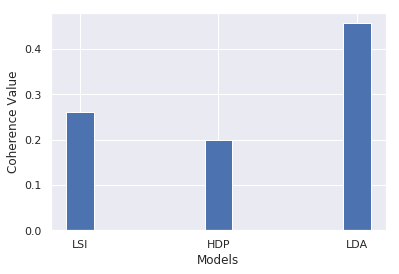

In [16]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence],
                   ['LSI', 'HDP', 'LDA'])

**Conclusions**

LDA model is the clear winner by far! In summary, we will use the LDA model with topic number of 10 in all the following analysis.

### Build the LDA model using the Sklearn

sklearn also has the generic LDA model, which has the benefit of easy intergration into the pyspark framework. We will develop this algorithm as a preparation for the spark.

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
tfidf_vectorizer = TfidfVectorizer(min_df = 10,
                                   tokenizer = prepare_text_for_lda)
dtm_tfidf = tfidf_vectorizer.fit_transform(proj_ABS['ABSTRACT_TEXT'])
lda_tfidf = LatentDirichletAllocation(n_components=10, 
                                      random_state=0, 
                                      learning_method = 'online')
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [ ]:
import pyLDAvis
import pyLDAvis.sklearn
lda_display_sk = pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer,mds = 'mmds')

In [41]:
pyLDAvis.display(lda_display_sk)

**Conclusions**

Results from the above shows that LDA using sklearn can have the same or even better results than those from gensim package in our analysis.

### Develop the spark algorithm

#### Simple preprocessing

In [7]:
abstract = sc.textFile(localpath('Data/test/'))
def text_cleaning(doc):
    '''lower case, clean words/symbols'''
    rm_list ='\"|\,|\(|  +|\)|\.|\'|\:'
    doc = re.sub(r'{}'.format(rm_list),' ',doc)
    doc = doc.strip().lower()
    return doc

stemmer = PorterStemmer()
def stem(words):
    '''Get the stem of the words'''
    words_stem = []
    for word in words:
        word_stem = stemmer.stem(word)
        if len(word_stem) > 2:
            words_stem.append(word_stem)
    return words_stem

df_abs = (abstract.map(lambda doc: text_cleaning(doc))
                  .filter(lambda doc: len(doc) > 0)
                  .filter(lambda line: not line.startswith('app'))
                  .map(lambda doc: doc.split(' '))
                  .map(lambda word: [x for x in word if len(x)>0])
                  .map(lambda word: stem(word))
                  .map(lambda doc: (int(doc[0]), doc[1:]))
                  .filter(lambda doc: len(doc[1])>0)
                  .toDF(['Id','words']))
df_abs.show(5)

+-------+--------------------+
|     Id|               words|
+-------+--------------------+
|3126545|[the, aim, thi, p...|
|3126549|[the, altern, pat...|
|3126553|[will, studi, vir...|
|3109190|[chronic, ingest,...|
|3109194|[the, effect, eth...|
+-------+--------------------+
only showing top 5 rows



Build the machine learning pipeline with the LDA model on spark:

In [8]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, Tokenizer, IDF
from pyspark.ml.feature import StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.clustering import LDA
from nltk.corpus import stopwords
# build the pipeline and lda model with online optimizer
stop_words = StopWordsRemover(inputCol='words',
                             outputCol='clean')
stop_words.setStopWords(stop_words.loadDefaultStopWords('english'))
countv = CountVectorizer(inputCol=stop_words.getOutputCol(), 
                         outputCol="tokens")
idf = IDF(inputCol=countv.getOutputCol(),outputCol="features")
lda = LDA(maxIter=10,k=10,optimizer='online')

pipeline = Pipeline(stages=[stop_words, countv, idf, lda])

lda_model = pipeline.fit(df_abs)

labels = lda_model.transform(df_abs)

In [38]:
lda_model.stages[3].logPerplexity(labels)

9.387032246261784

In [9]:
# identify the label as the topic with the max probability
# save the label to file
if os.path.exists('Data/Topics/'):
    os.system('rm -r Data/Topics/')
topic_labels = (labels.select('Id','topicDistribution')
                      .rdd
                      .map(lambda x: (x[0],np.argmax(x[1])))
                      .saveAsTextFile(localpath('Data/Topics/labels/')))
# Get the topics
wordnum = 5 # choose the number of topic words
vocabulary = lda_model.stages[1].vocabulary
# make the vocabulary the broadcast variable to all the nodes
# convert the topics from indices to actual words and store them
voc_bv = sc.broadcast(vocabulary)
topic_df =(lda_model.stages[3].describeTopics(wordnum)
                    .rdd
                    .map(lambda x:(x[0],[voc_bv.value[Id] for Id in x[1]],x[2]))
                    .saveAsTextFile(localpath('Data/Topics/words/')))

In [10]:
# combine the results into one file
os.system('cat Data/Topics/words/* | sort -n -t , -k 1.2 -o Data/Topics/words/combined_output')
# verify the topic words:
with open('Data/Topics/words/combined_output','r') as f:
    topic_words = f.read()
print(topic_words)

(0, ['cell', 'platelet', 'iga', 'fetal', 'endotheli'], [0.002355404214509733, 0.002251015636469178, 0.0022480795384913206, 0.002046123417904411, 0.0019777638523965574])
(1, ['airway', 'abstract', 'asthma', 'bronchial', 'mmc'], [0.0049766394583142925, 0.002745436356634422, 0.0016623497668577876, 0.001566055733559468, 0.001346054369163372])
(2, ['patient', 'cancer', 'program', 'research', 'clinic'], [0.0038954760912011163, 0.0035309530247389868, 0.003265254757673032, 0.0031469828334711094, 0.002915283815549397])
(3, ['p21', 'nzb', 'sbp', 'rsv', 'cam'], [0.002131098788836691, 0.0020365867406738278, 0.0017245935378808472, 0.0016880011743039696, 0.0013336110735850239])
(4, ['gene', 'dna', 'sequenc', 'cell', 'express'], [0.00865853275130002, 0.006487467091679806, 0.003464275659061703, 0.00336740780643224, 0.003310606916516731])
(5, ['cell', 'protein', 'membran', 'receptor', 'enzym'], [0.004871452748160377, 0.004049316635055094, 0.0036738361207297484, 0.0034550702275470274, 0.0029826123429263

Testing the scripts on the local `Hadoop` file system:

In [ ]:
!hadoop fs -rm -r hdfs:///user/vagrant/output/
!spark-submit --master local[*] --py-files myutils.py grant.py \
    hdfs:///user/vagrant/test/ hdfs:///user/vagrant/output/

In [64]:
!rm -r output
!mkdir output
!hadoop fs -copyToLocal hdfs:///user/vagrant/output/* output/

rm: cannot remove 'output': No such file or directory


## Phase II: Run the whole LDA learning on GCP

The following commands need to be implemented in the **terminal** because GCP terminal commands cannot be run in the notebook:

In [ ]:
# delete the output folder if it already exists
!gsutil rm -r gs://camalot/output

Need to make sure that the `cluster_init.sh` has the necessary packages including `numpy` and `ntlk`:

In [ ]:
# more powerful
!gcloud dataproc clusters create cluster-1 --initialization-actions \
    gs://camalot/cluster_init.sh --region us-west2 --zone us-west2-a \
    --master-machine-type n1-standard-2 --master-boot-disk-size 500GB \
    --num-workers 3 \
    --worker-machine-type n1-standard-4 --worker-boot-disk-size 500GB \
    --num-worker-local-ssds 1 --project tdi2018-217422

In [ ]:
!gcloud dataproc jobs submit pyspark --cluster cluster-1 --region us-west2 \
    --py-files gs://camalot/datacourse/grant_tracking/myutils.py \
    gs://camalot/datacourse/grant_tracking/grant.py \
    -- gs://camalot/data/NIH/PRJABS/ \
            gs://camalot/output/

In [ ]:
# shut down cluster at the end
!gcloud dataproc clusters delete cluster-1 --region us-west2

Retrieve the results from the GCP:

In [ ]:
!mkdir Data/TOPICS
!gsutil -m cp -r gs://camalot/output/* Data/TOPICS/

In [1]:
# concatenate the results
!cat Data/TOPICS/words/* | sort -n -t , -k 1.2 -o Data/TOPICS/words/combined_output

In [6]:
# cleanup the folders
os.system('rm -r Data/Topics/')
os.system('rm -r Data/test/')
# verify the topic words:
with open('Data/TOPICS/words/combined_output','r') as f:
    topic_words = f.read()
print(topic_words)

(0, ['cell', 'tumor', 'cancer', 'prostat', 'gene'], [0.0060956335214564245, 0.005086222044144851, 0.005009430868627323, 0.003697609280935412, 0.003460281903900874])
(1, ['cell', 'gene', 'protein', 'regul', 'express'], [0.004594317133466091, 0.0038059075988859407, 0.0036379725226937673, 0.0033328298824014378, 0.00326685406728959])
(2, ['neuron', 'channel', 'receptor', 'brain', 'synapt'], [0.007042041003360923, 0.004077683318602762, 0.0036164204495745594, 0.003308430357232393, 0.0032883397230235346])
(3, ['bone', 'metabol', 'cell', 'enzym', 'protein'], [0.0034578079859153266, 0.0029465397472412886, 0.0028175928610289554, 0.0025864548009336703, 0.0024943984724672837])
(4, ['imag', 'bone', 'cell', 'cancer', 'tissu'], [0.003602599266769546, 0.002119818322510824, 0.0020309181668803087, 0.0019416640338134948, 0.001716619744709918])
(5, ['core', 'research', 'cancer', 'clinic', 'center'], [0.004496693876002155, 0.004455518910845751, 0.003280833111808586, 0.0032192730845144557, 0.003155290200665

**Conclusions**

The results look good. Just by glancing, we know that `cancer` takes 3 out of 10 topics we classified from the abstracts of all the grants between 1985 and 2017.

In [19]:
sc.stop()